In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
warnings.filterwarnings('ignore')

import sklearn.linear_model as lm
import sklearn.ensemble as en

import torch
import os
import sys
sys.path.append(os.path.abspath('../python'))

import train_arvae
import verify_causal_model

# DGP + Synthetic Control

$y_i(0) = \mu_i \lambda_t + \delta_t + \epsilon_{i,t}$ \
$y_i(1) = \alpha_{i,t} + y_i(0)$

In [10]:
def gen_data( n_donor=10, T=20, T0=12, noise=1 ):
    lmbda = np.random.normal(0,1,size=(T,1))
    delta = np.random.normal(0,1,size=(T,1))
    mu = np.random.normal(0,1,size=(1+n_donor,1))
    epsilon = np.random.normal(0,1,size=(T,1+n_donor))
    y0 = np.matmul(lmbda,mu.T) + np.matmul(delta,np.ones((1,1+n_donor))) + epsilon
    y1 = y0
    intervention = np.zeros((T,1+n_donor))
    intervention[T0:T,0] = 1
    y = intervention*y1 + (1-intervention)*y0
    return y,intervention,y1,y0

def synthetic_control( y, T0 ):
    y_target = y[:,0]
    y_donors = y[:,1:]
    ypre_target = y[:T0,0]
    ypre_donors = y[:T0,1:]
    m_lasso = lm.LassoCV().fit(ypre_donors,ypre_target)
    y_target_lasso = m_lasso.predict(y_donors)
    effect = y_target - y_target_lasso
    return effect, y_target, y_target_lasso

In [13]:
n_donor=10 
T=20
T0=12
noise=1 
y,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=noise )

In [17]:
effect, y_target, y_target_lasso = synthetic_control( y, T0 )

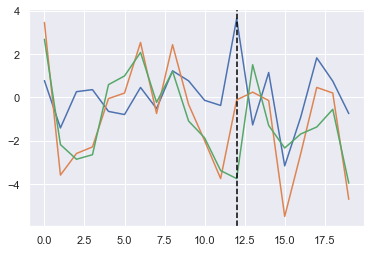

In [18]:
plt.plot(effect)
plt.plot(y_target)
plt.plot(y_target_lasso)
plt.axvline(T0,c='black',ls='--')

# Credence